In [1]:
#imports
import matplotlib.pyplot as plt
 
import pandas as pd
import itertools
import numpy as np
 
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
)
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
import folium 

from itertools import combinations
 
#loading the Dataset into a pandas dataframe
df = pd.read_csv('Airlines.csv')
allAirports = pd.read_csv('AllAirports.csv')


# Select features and target variable (id is not needed)
features = ['Airline', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time', 'Length']
target = 'Delay'
X = df[features]
y = df[target]

#Preprossing of the data
encoder = preprocessing.OrdinalEncoder()
encoded = pd.DataFrame(encoder.fit_transform(X[['Airline', 'AirportFrom', 'AirportTo']]), columns = encoder.get_feature_names_out(['Airline', 'AirportFrom', 'AirportTo']))

X = X.drop(columns = ['Airline', 'AirportFrom', 'AirportTo'])
X = X.join(encoded)

# Separate continuous and categorical columns
continuous_cols = ['DayOfWeek', 'Time', 'Length']
categorical_cols = [col for col in X.columns if col not in continuous_cols]



# Instantiate MinMaxScaler
min_max_scaler = MinMaxScaler()

# Apply MinMaxScaler only to continuous columns
X[continuous_cols] = min_max_scaler.fit_transform(X[continuous_cols])


print(X)
print(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% training and 20% testing

        DayOfWeek      Time    Length  Airline  AirportFrom  AirportTo
0        0.333333  0.003499  0.312977      4.0        253.0      135.0
1        0.333333  0.003499  0.338931     14.0        217.0       60.0
2        0.333333  0.006998  0.251908      1.0        154.0       80.0
3        0.333333  0.006998  0.297710      1.0        253.0       80.0
4        0.333333  0.013996  0.308397      2.0         14.0      252.0
...           ...       ...       ...      ...          ...        ...
539378   0.666667  1.000000  0.497710      4.0        203.0      264.0
539379   0.666667  1.000000  0.465649      8.0        252.0       16.0
539380   0.666667  1.000000  0.389313      8.0        253.0      184.0
539381   0.666667  1.000000  0.477863     13.0        128.0      253.0
539382   0.666667  1.000000  0.459542     14.0        154.0      216.0

[539383 rows x 6 columns]
0         1
1         1
2         1
3         1
4         0
         ..
539378    0
539379    0
539380    0
539381    1
5

e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=20. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
e:\Anaconda\envs\ATIT\lib\site-packages\sklearn\model_selection\

[3, 0.6261668381582729, 0.6240307257951163, 0.7691605839416058, 0.22832201341722572, 0.35211901166340004, {'min_samples_split': 2, 'min_samples_leaf': 1, 'criterion': 'gini'}]


<Figure size 1000x1000 with 0 Axes>

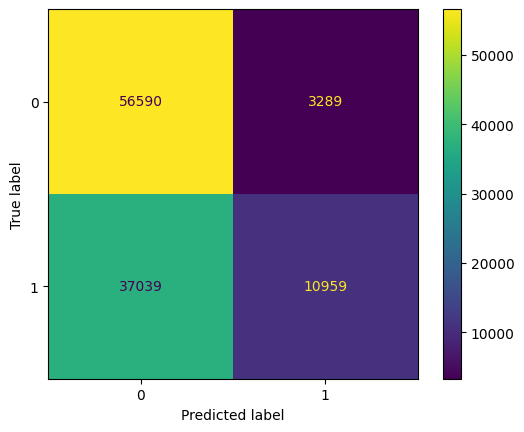

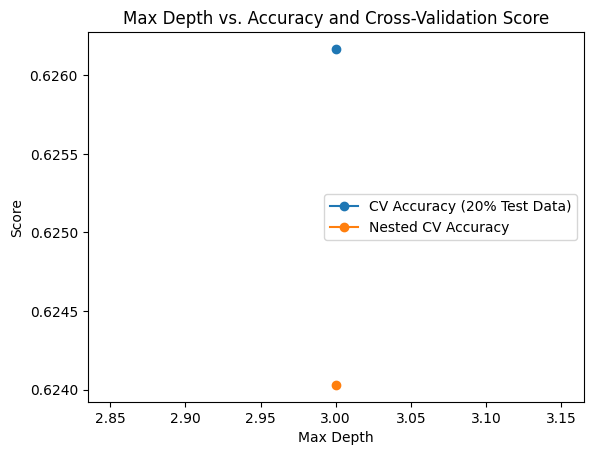

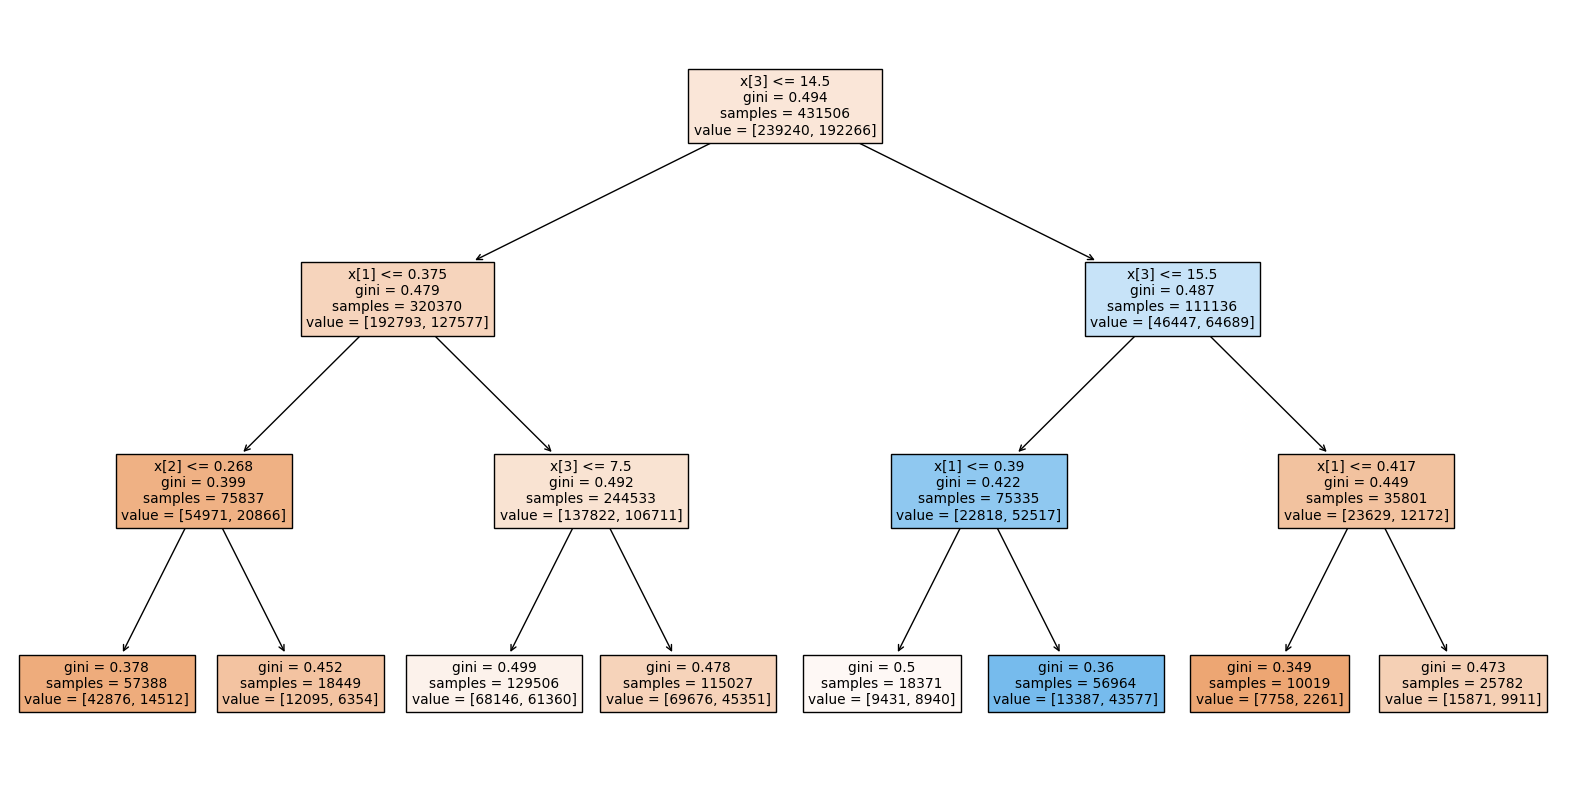

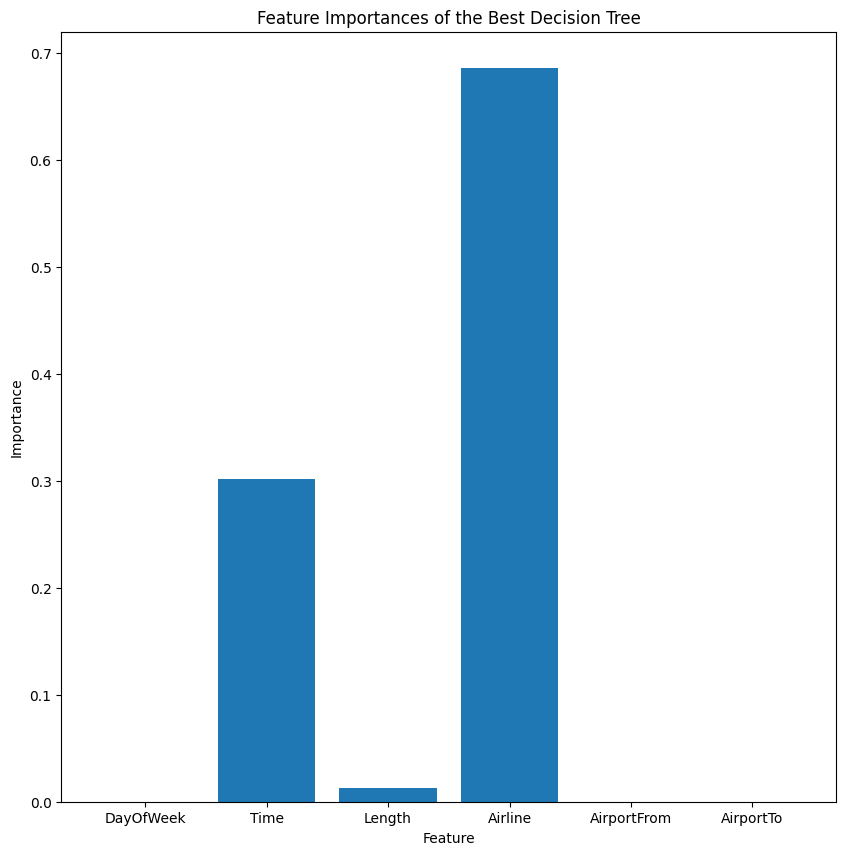

In [9]:
# Create an array to store results
results_array = []
accuracies = []
depths = []
cv_scores = []
higehstAccuracy = 0

# Specify the parameters for the random search
param_dist = {
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    #'min_samples_split': range(2, 3),
    #'min_samples_leaf': range(1, 2),
    'criterion': ['gini', 'entropy']
}

# Number of random samples
n_iter_search = 20

# Define the KFold for the outer loop
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)


# Loop through each depth and perform random search
for depth in range(3, 18):
    tree = DecisionTreeClassifier(random_state=42, max_depth=depth)
    
    random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=n_iter_search, scoring='accuracy', cv=kfolds, random_state=42)
    random_search.fit(X_train, y_train)
    
    # Perform nested cross-validation
    cv_score = cross_val_score(random_search, X_train, y_train, cv=kfolds, scoring=make_scorer(accuracy_score))
    
    # Test on the other 20%
    clf = Pipeline([('classifier', random_search.best_estimator_)])

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store results in array
    results_array.append([depth, accuracy, cv_score.mean(), precision, recall, f1,random_search.best_params_])
    accuracies.append(accuracy)
    depths.append(depth)
    cv_scores.append(cv_score.mean())

    print(results_array[-1])

    if higehstAccuracy < cv_scores[-1]:
        cm = confusion_matrix(y_test, y_pred)
        bestTree = clf
        importanceBest = clf['classifier'].feature_importances_

# plot the cm 
plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot()
plt.show()


#plot for depth and accuracy
plt.plot(depths, accuracies, marker='o', label="CV Accuracy (20% Test Data)")
plt.plot(depths, cv_scores, marker='o', label="Nested CV Accuracy")
plt.legend()
plt.title('Max Depth vs. Accuracy and Cross-Validation Score')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.savefig("graphs/dtNestedCvaAcc.pdf")
plt.show()

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(bestTree['classifier'], filled=True)
plt.savefig("graphs/dtNestedCv.pdf")
plt.show()

# Plotte die Feature-Importances mit den Namen der Features
plt.figure(figsize=(10, 10))
plt.bar([x for x in range(len(importanceBest))], importanceBest, tick_label=X_train.columns)
plt.title('Feature Importances of the Best Decision Tree')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()
